In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test

In [2]:
#clinical
clinical_path = r"clinical.csv"
clinical = pd.read_csv(clinical_path, index_col=0)


#signatures
signatures_path=r"Lung_NSCLC2.tsv"
signatures=pd.read_csv(signatures_path, sep='\t')
signatures=signatures.drop(columns=['sample_vs_control', 'accuracy'])
signatures['Smoking']=signatures['SBS4']+signatures['SBS92']
signatures['APOBEC']=signatures['SBS2']+signatures['SBS13']
signatures['Age_related']=signatures['SBS1']+signatures['SBS5']

#IF2
data2=r"phenotype_translating_result_IF2.tsv"
df2=pd.read_csv(data2, sep='\t')
df2.drop(columns=df2.columns[0], axis=1, inplace=True)

In [3]:
def kaplan_meier_plot(data, groups, event, duration, condition=None):

    plt.figure(figsize=(7, 5))

    group_list = data[groups].unique()

    # chosing groups, so coloors are consistent
    if group_list[0].startswith('Low'):
        groupA_name=group_list[0]
        groupA = data[data[groups] == group_list[0]]
        groupB_name=group_list[1]
        groupB = data[data[groups] == group_list[1]]
    
    else:
        groupB_name=group_list[0]
        groupB = data[data[groups] == group_list[0]]
        groupA_name=group_list[1]
        groupA = data[data[groups] == group_list[1]]


    kmf = KaplanMeierFitter()
    for group in (groupA_name, groupB_name):
        group_data = data[data[groups] == group]
        kmf.fit(durations=group_data[duration], event_observed=group_data[event], label=group)
        kmf.plot(ci_show=True)  # showing confidence interval


    

    if len(group_list)==1:
        return False


    results = logrank_test(groupA[duration], groupB[duration],
                        event_observed_A=groupA[event],
                        event_observed_B=groupB[event])

    if results.p_value< 0.05:
        if condition:
            plt.title(f"Kaplan-Meier plot for {groups} in {condition} high")
        else:
            plt.title(f"Kaplan-Meier plot for {groups}")
        plt.xlabel("Time (Days)")
        plt.ylabel("Survival probability")
        plt.legend()
        plt.grid()
        plt.show()

        print(results.summary)
        plt.close()
        return True

    plt.close()
    return False

In [4]:
# two conditions with 0 split

def KP3 (clinical, data1, data2, con1, con2):
    plt.figure(figsize=(7, 5))


    df_plot = pd.merge(clinical[["immucan_id", "death", "time_to_event"]], data1[["patient", con1]], left_on="immucan_id", right_on="patient")
    df_plot = df_plot.drop(columns=['patient'])
    df_plot = pd.merge(df_plot, data2[["patient", con2]], left_on="immucan_id", right_on="patient")
    df_plot = df_plot.drop(columns=['patient'])

    df_plot = df_plot[df_plot[con1] > 0]

    med = df_plot[con2].median()
    df_plot[f'{con2}_group'] = df_plot[con2].apply(lambda x: f'High_{con2}' if x > med else f'Low_{con2}')

    df_plot['death'] = df_plot['death'].map({"Yes": 1, "No": 0})
    if kaplan_meier_plot(df_plot, f'{con2}_group', 'death', 'time_to_event', condition=con1):
        plt.close()
        return True
    plt.close()
    return False


<Figure size 700x500 with 0 Axes>

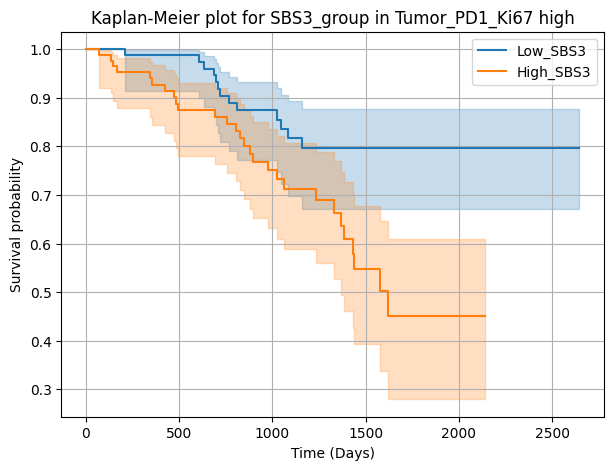

   test_statistic         p  -log2(p)
0        6.952878  0.008368  6.900824


<Figure size 700x500 with 0 Axes>

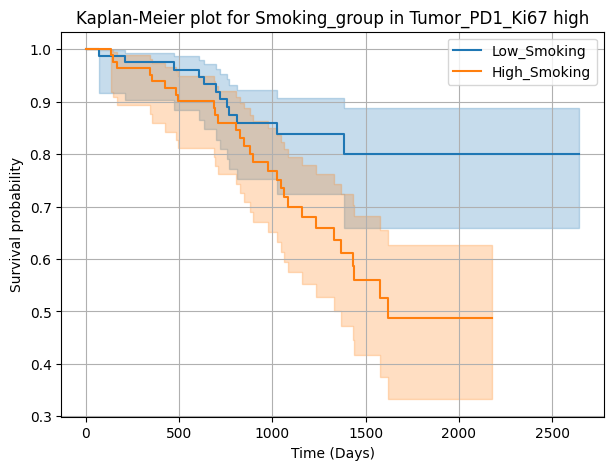

   test_statistic         p  -log2(p)
0        6.229854  0.012561  6.314858


<Figure size 700x500 with 0 Axes>

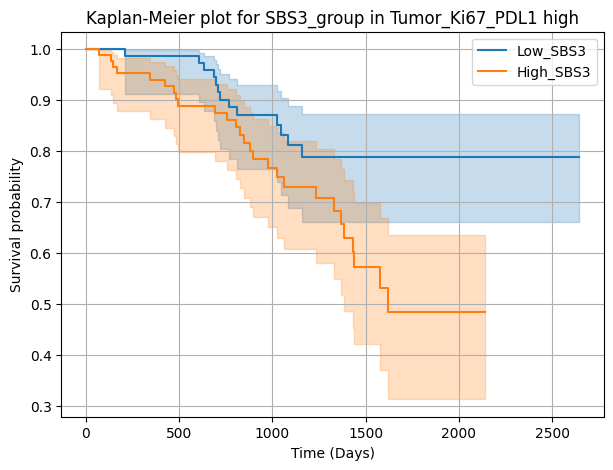

   test_statistic         p  -log2(p)
0        5.054783  0.024558  5.347659


<Figure size 700x500 with 0 Axes>

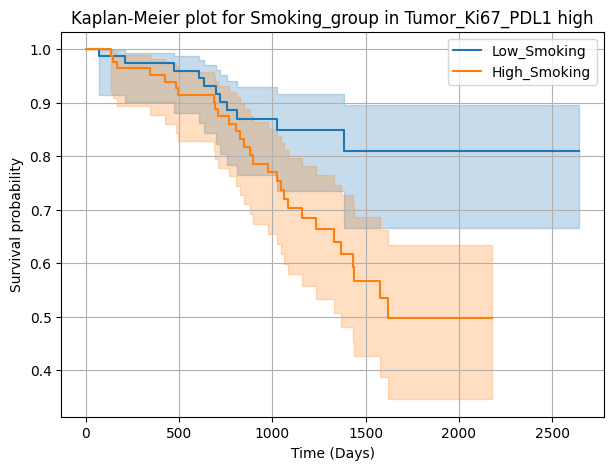

   test_statistic         p  -log2(p)
0        6.392362  0.011461  6.447093



Number of significant (cell, sig) conditions with 0 split: 4


In [6]:
# two conditions (1: IF2, 2: signatures) with 0 and median split
count = 0

for celltype in ["Tumor_PD1_Ki67", "Tumor_Ki67_PDL1"]:    
    for sig in ['SBS3', 'Smoking']:
        check = KP3(clinical, df2, signatures, celltype, sig)
        count += check

print('\n\n')
print(f"Number of significant (cell, sig) conditions with 0 split: {count}")
